## **Problem Statement:** 
#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

---

#### Project Pipeline:
##### 1. Data Reading/Data Understanding (Importing Skin Cancer ISIC Data)
##### 2. Dataset Creation
##### 3. Dataset Visualisation
##### 4. Model Building & Training (1st Model)
##### 5. Choose an appropriate data augmentation strategy to resolve underfitting/overfitting
##### 6. Model Building & training on the augmented data (2nd Model)
##### 7. Class distribution
##### 8. Handling class imbalances
##### 9. Model Building & training on the rectified class imbalance data (3rd Model)

---

### 1. Data Reading/Data Understanding (Importing Skin Cancer ISIC Data)

In [1]:
# Importing all the important libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom,RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models

!pip install Augmentor
import Augmentor

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install --upgrade Pillow

In [3]:
import pathlib
from PIL import Image

# Root directory
root_dir = pathlib.Path('/Users/i/Downloads/Melanoma_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration')

# Check if the root directory exists
if not root_dir.exists():
    print(f"Directory (root_dir) does not exist.")

data_dir_train = root_dir / 'Train'
data_dir_test = root_dir / 'Test'

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

---

### 2. Dataset Creation:

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

##### Use 80% of the images for training, and 20% for validation.

In [6]:
## Creating train dataset here
## Used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized the images to the format img_height*img_width, while creating the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Creating validation dataset here
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized the images to the size img_height*img_width, while creating the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and storing them in a list.
# We can find the class names in the "class_names" attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


---

### 3. Dataset Visualisation

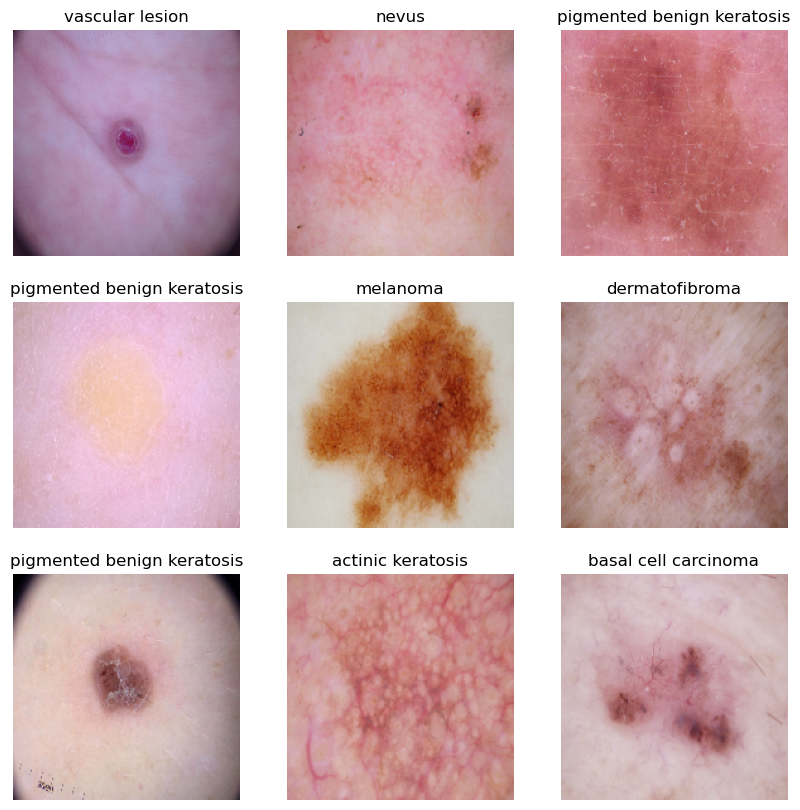

In [9]:
# Creating a code to visualize one instance of all the nine classes present in the training dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

### 4. Model Building & Training (1st Model)

#### Creating 1st CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]` range.

#### Creating 1st model

In [11]:
# Number of target labels are 9
target_labels = 9

model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [14]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.2199 - loss: 2.0903 - val_accuracy: 0.3937 - val_loss: 1.6835
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.4041 - loss: 1.6292 - val_accuracy: 0.4698 - val_loss: 1.5327
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.5043 - loss: 1.4651 - val_accuracy: 0.5168 - val_loss: 1.4692
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.5387 - loss: 1.3035 - val_accuracy: 0.5369 - val_loss: 1.3385
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.5571 - loss: 1.2188 - val_accuracy: 0.5414 - val_loss: 1.3213
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.6078 - loss: 1.0953 - val_accuracy: 0.5548 - val_loss: 1.3928
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.6230 - loss: 1.0331 - val_accuracy: 0.5503 - val_loss: 1.4078
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.6637 - loss: 0.9567 - val_accu

#### Visualizing training results

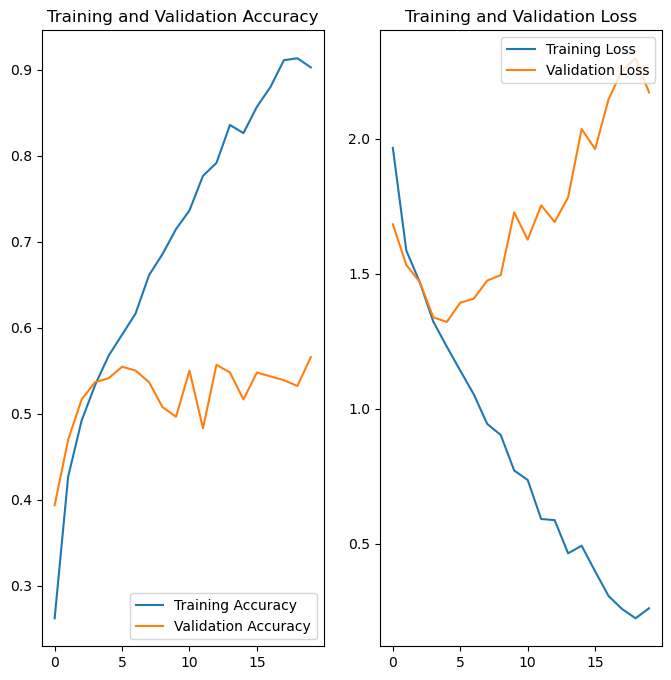

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. The model's training accuracy shows a steady increase of upto 92%, while validation accuracy remains consistently around 57%.

2. A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

---

### 5. Choose an appropriate data augmentation strategy to resolve underfitting/overfitting

In [16]:
# After we have analysed the model fit history for presence of underfit or overfit, we chose an appropriate data augumentation strategy.

augmentation_data = models.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

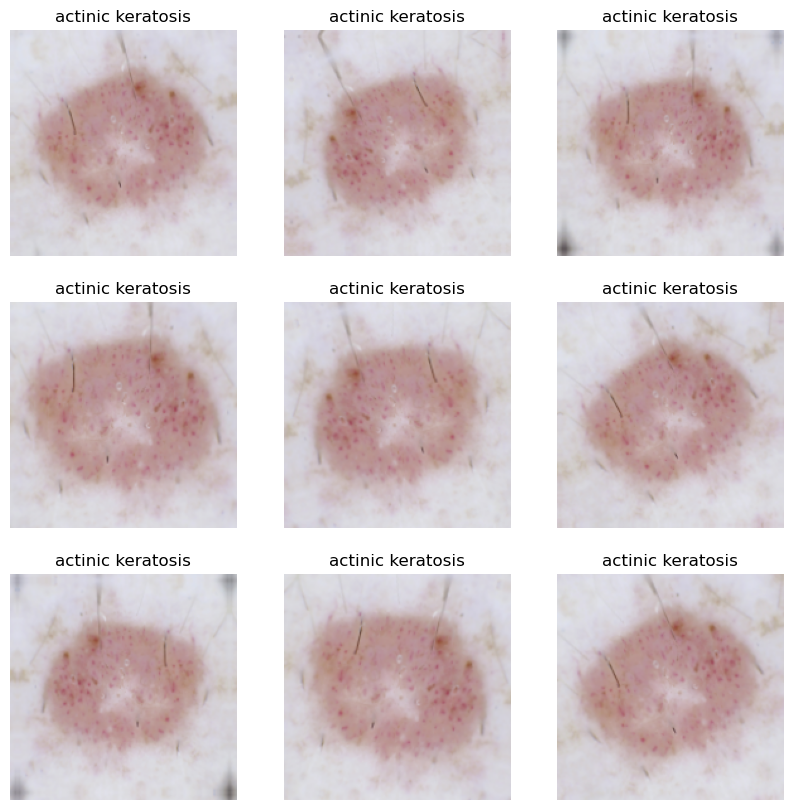

In [17]:
# Visualizing how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

---

### 6. Model Building & training on the augmented data (2nd Model)

#### Creating the 2nd model

In [18]:
## WE can use Dropout layer if there is an evidence of overfitting in our findings

model = models.Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [20]:
%%time
## Training your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.2107 - loss: 2.2566 - val_accuracy: 0.2640 - val_loss: 1.8440
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.3205 - loss: 1.8019 - val_accuracy: 0.4474 - val_loss: 1.5932
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step - accuracy: 0.4457 - loss: 1.5866 - val_accuracy: 0.4787 - val_loss: 1.5528
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - accuracy: 0.4765 - loss: 1.4784 - val_accuracy: 0.4340 - val_loss: 1.5673
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.5065 - loss: 1.4296 - val_accuracy: 0.5056 - val_loss: 1.3969
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.4979 - loss: 1.3615 - val_accuracy: 0.5369 - val_loss: 1.3520
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.5529 - loss: 1.2979 - val_accuracy: 0.5235 - val_loss: 1.3496
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.5281 - loss: 1.3097 - val_accu

#### Visualizing training results

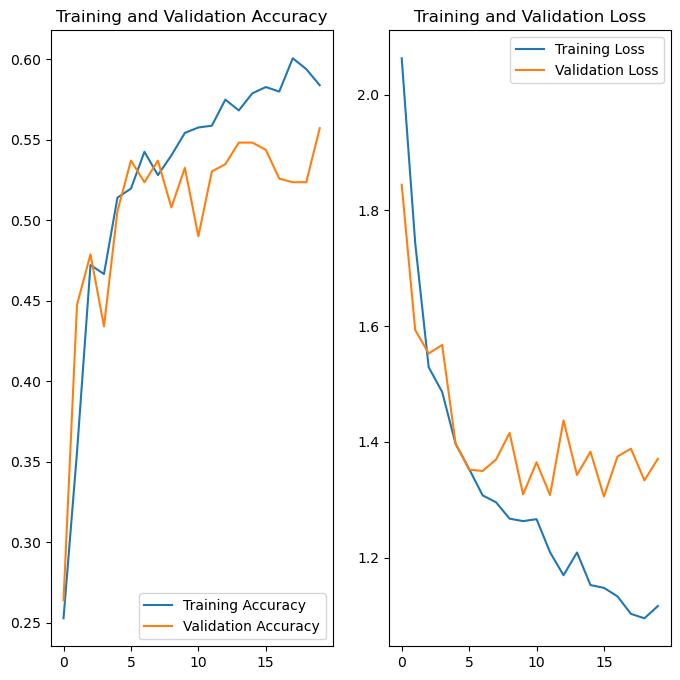

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

---

### 7. Class distribution

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
from glob import glob

## finding the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extracting the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [23]:
# Extracting image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [24]:
# Viewing the image paths and class labels in a dataframe
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
1,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
2,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
3,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
4,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis


In [25]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

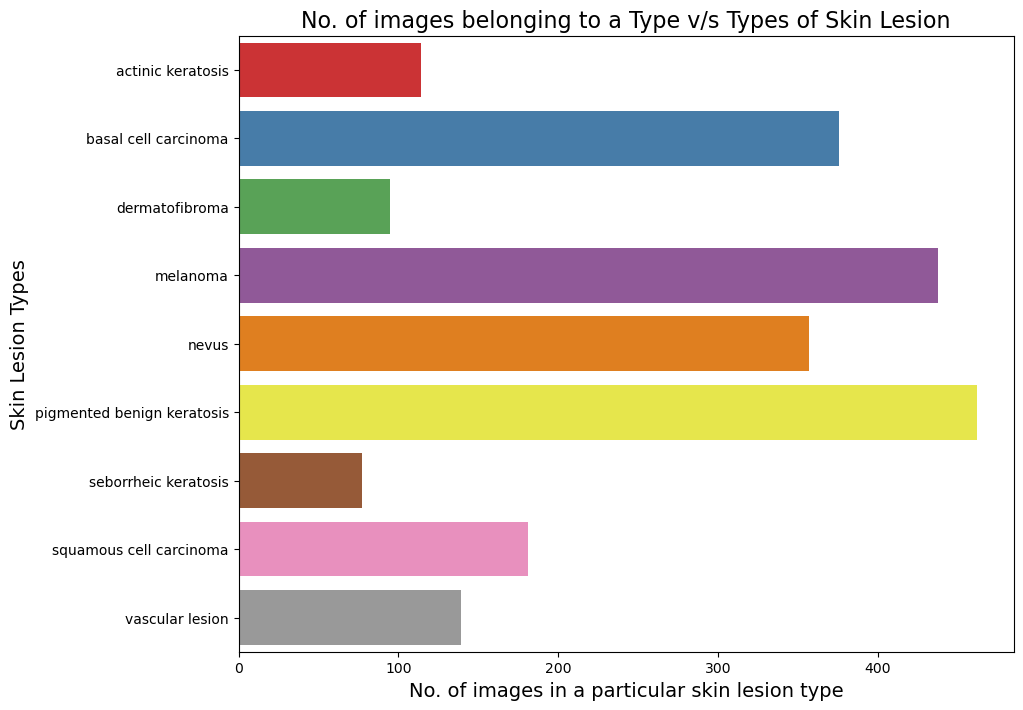

In [26]:
# Visualizing the distribution of classes using a countplot

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette="Set1")
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [27]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

---

### 8. Handling class imbalances
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [28]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2105F327560>: 100%|█| 500/500 [00:04<00:00, 105.30 Samples


Initialised with 376 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2105323C680>: 100%|█| 500/500 [00:04<00:00, 106.44 Samples


Initialised with 95 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2105F20C470>: 100%|█| 500/500 [00:04<00:00, 105.90 Samples


Initialised with 438 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x210BE8807A0>: 100%|█| 500/500 [00:26<00:00, 18.63 Samples


Initialised with 357 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x210C0A45760>: 100%|█| 500/500 [00:22<00:


Initialised with 462 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x210BE84F6E0>: 100%|█| 500/500 [00:05<00:00, 94.73 Samples/


Initialised with 77 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2105BB07440>: 100%|█| 500/500 [00:11<00:00, 43.22 Samples


Initialised with 181 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21077CE1BE0>: 100%|█| 500/500 [00:05<00:00, 94.64 Samples/


Initialised with 139 image(s) found.
Output directory set to \Users\i\Downloads\Melanoma_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x210C0A4EC60>: 100%|█| 500/500 [00:05<00:


#### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [29]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_168f01b9-1ad2-4a88-b736-3dbf2e76e40f.jpg',
 '\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_453c0777-52cb-45fa-881f-cde2e8b3d674.jpg',
 '\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_76c8d45d-61f3-4d0f-b41f-aa7239f483ca.jpg',
 '\\Users\\i\\Downloads\\Melanoma_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c5e441c3-ee8e-4e50-8a06-6ceb788e15ec.jpg',
 '\\Users\\i\\Do

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df,df2])
new_df.shape

(6739, 2)

In [34]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
1,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
2,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
3,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis
4,\Users\i\Downloads\Melanoma_Assignment\CNN_ass...,actinic keratosis


In [35]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [36]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64

#### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

---

### 9. Model Building & training on the rectified class imbalance data (3rd Model)

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [39]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [40]:
val_ds2 =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating 3rd model

In [41]:
## Architecture

#Sequential allows you to create models layer-by-layer
model3 = models.Sequential()

model3.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(64,activation='relu'))

#Dropout layer with 12% Fraction of the input units to drop.
model3.add(layers.Dropout(0.12))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,633 (6.34 MB)

 Trainable params: 1,662,633 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model

In [42]:
### Todo, choose an appropirate optimiser and loss function
model3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model on the data created using Augmentor

In [43]:
epochs = 40
history3 = model3.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.1613 - loss: 2.1471 - val_accuracy: 0.3823 - val_loss: 1.5653
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - accuracy: 0.3744 - loss: 1.5930 - val_accuracy: 0.4380 - val_loss: 1.4650
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - accuracy: 0.4615 - loss: 1.4144 - val_accuracy: 0.5316 - val_loss: 1.3027
Epoch 4/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.5263 - loss: 1.2777 - val_accuracy: 0.5375 - val_loss: 1.2351
Epoch 5/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - accuracy: 0.5619 - loss: 1.1841 - val_accuracy: 0.5805 - val_loss: 1.1487
Epoch 6/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.6054 - loss: 1.0506 - val_accuracy: 0.5360 - val_loss: 1.2462
Epoch 7/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.6315 - loss: 0.9887 - val_accuracy: 0.6399 - val_loss: 0.9852
Epoch 8/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.6662 - loss: 0

#### Visualize the model results

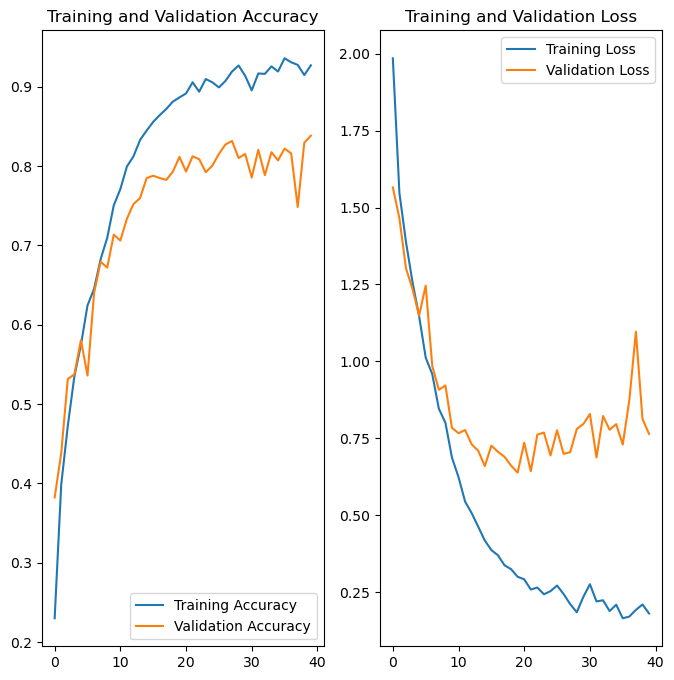

In [45]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Observations:
1. The ultimate model (3rd model) showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.
 
3. Following 40 epochs, the final model attains an accuracy of 92% on the training set and approximately 84% on the validation set.
 
4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


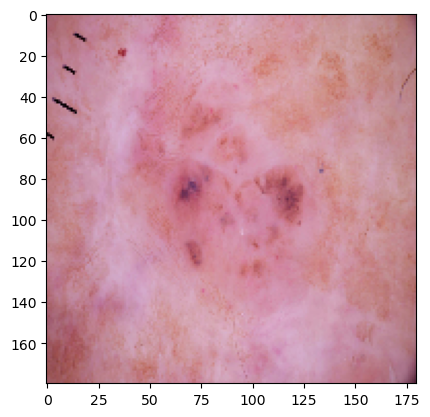

In [46]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model3.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)